In [1]:
%%bash
pip install seaborn
pip install mlpy

  Running setup.py bdist_wheel for seaborn: started
  Running setup.py bdist_wheel for seaborn: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/cb/c8/67/83d615c0ef9b529558525aa521025b183de8c5b156799b091e
Successfully built seaborn
  Running setup.py bdist_wheel for mlpy: started
  Running setup.py bdist_wheel for mlpy: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/70/85/c2/68d906f0b0dd73fa710cc99090752eab96637f7bed1f61e52e
Successfully built mlpy


/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:318: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/pyth

In [2]:
import numpy as np

import os
import inspect
import sys
import pandas as pd
import charts
import time

from opengrid.library import houseprint

from scipy.signal import butter, lfilter, freqz

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

Server running in the folder /usr/local/opengrid/notebooks/Analysis/Thesis_Max&Jean at 127.0.0.1:55542


<h3>Create two signals to compare to each other</h3>

In [3]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
30 Sites created
30 Devices created
87 sensors created
Houseprint parsing complete


In [4]:
gas = hp.find_sensor('212ce724e124fbde0fb649396375d099')

#Timeseries 1
head = pd.Timestamp('2015-11-14 15:22:00')
tail = pd.Timestamp('2015-11-14 16:49:00')
ts_1 = gas.get_data(head=head, tail=tail, diff=True, resample='min', unit='kW')
ts_1 = ts_1.append(pd.DataFrame(data=[0], index=[ts_1.index[ts_1.size-1] + 1]))

#Timeseries 2
head = pd.Timestamp('2015-11-14 16:49:00')
tail = pd.Timestamp('2015-11-14 18:26:00')
ts_2 = gas.get_data(head=head, tail=tail, diff=True, resample='min', unit='kW')
ts_2 = ts_2.append(pd.DataFrame(data=[0], index=[ts_2.index[ts_2.size-1] + 1]))

#concatinate them
samples = pd.concat([ts_1, ts_2], axis=1).fillna(0)
samples.columns = ['ts_1', 'ts_2']

charts.plot(samples, stock=True, show='inline')

Using tmpo database from /data/.tmpo/tmpo.sqlite3


Convert time samples to np arrays

In [5]:
ts_1 = ts_1.fillna(0).as_matrix()
ts_2 = ts_2.fillna(0).as_matrix()

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


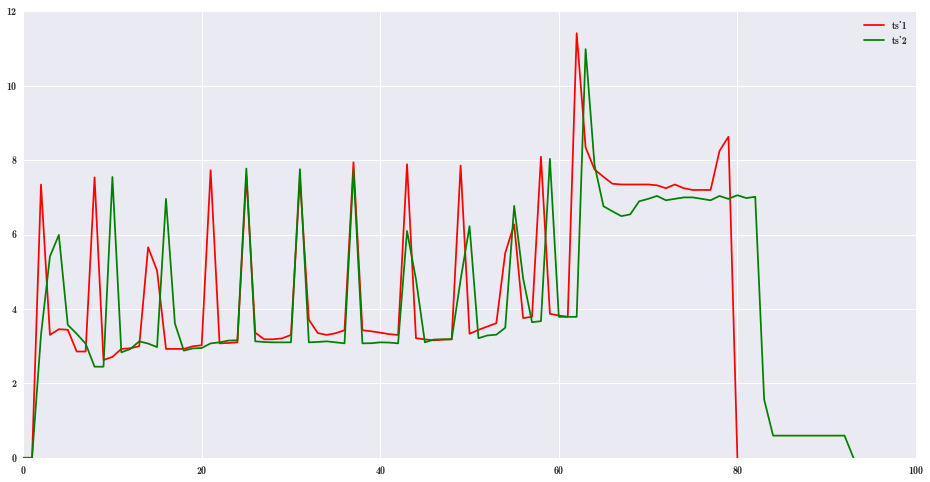

In [6]:
plt.plot(ts_1,'r', label='ts_1')
plt.plot(ts_2, 'g', label='ts_2')
plt.legend();

In this initial step, we will find out the distance between all pair of points in the two signals. Lesser distances implies that these points may be candidates to be matched together.

In [7]:
distances = np.zeros((len(ts_1), len(ts_2)))

We will use euclidean distance between the pairs of points.

In [8]:
for i in range(len(ts_1)):
    for j in range(len(ts_2)):
        distances[i,j] = (ts_2[j]-ts_1[i])**2  

<h3>Visualizing the distance matrix</h3>

We will write a small function to visualize the distance matrix we just created.

In [9]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.xlabel("ts_2")
    plt.ylabel("ts_1")
    plt.grid()
    plt.colorbar();

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


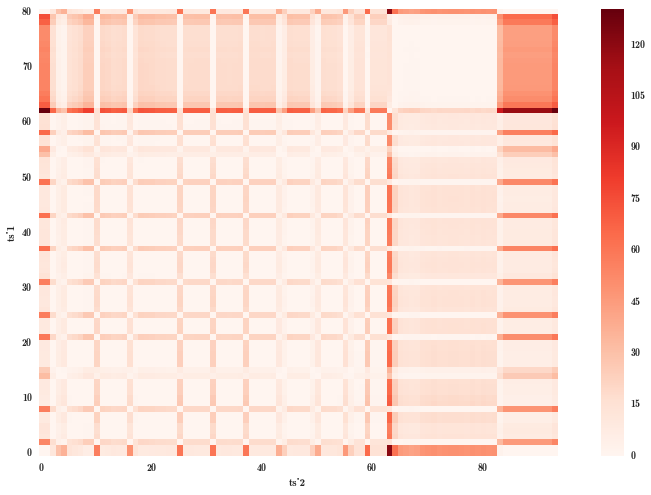

In [10]:
distance_cost_plot(distances)

Warping path

In order to create a mapping between the two signals, we need to create a path in the above plot. The path should start at (0,0) and want to reach (M,N) where (M, N) are the lengths of the two signals. Our aim is to find the path of minimum distance. To do this, we thus build a matrix similar to the distances matrix. This matrix would contain the minimum distances to reach a specific point when starting from (0,0). We impose some restrictions on the paths which we would explore:

The path must start at (0,0) and end at (M,N)
We cannot go back in time, so the path only flows forwards, which means that from a point (i, j), we can only right (i+1, j) or upwards (i, j+1) or diagonal (i+1, j+1).
These restrictions would prevent the combinatorial explosion and convert the problem to a Dynamic Programming problem which can be solved in O(MN) time.

In [11]:
accumulated_cost = np.zeros((len(ts_1), len(ts_2)))

In [12]:
accumulated_cost[0,0] = distances[0,0]

In [17]:
for i in range(1, len(ts_1)):
    for j in range(1, len(ts_2)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]

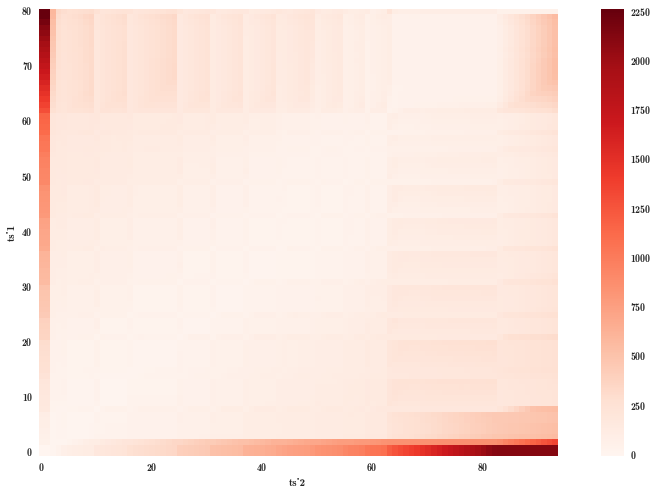

In [18]:
distance_cost_plot(accumulated_cost)

Backtracking and finding the optimal warp path¶

Backtracking procedure is fairly simple and involves trying to move back from the last point (M, N) and finding which place we would reached there from (by minimizing the cost) and do this in a repetitive fashion.

In [19]:
path = [[len(ts_2)-1, len(ts_1)-1]]
i = len(ts_1)-1
j = len(ts_2)-1
while i>0 and j>0:
    if i==0:
        j = j - 1
    elif j==0:
        i = i - 1
    else:
        if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            i = i - 1
        elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            j = j-1
        else:
            i = i - 1
            j= j- 1
    path.append([j, i])
path.append([0,0])

In [20]:
path_ts_2 = [point[0] for point in path]
path_ts_1 = [point[1] for point in path]

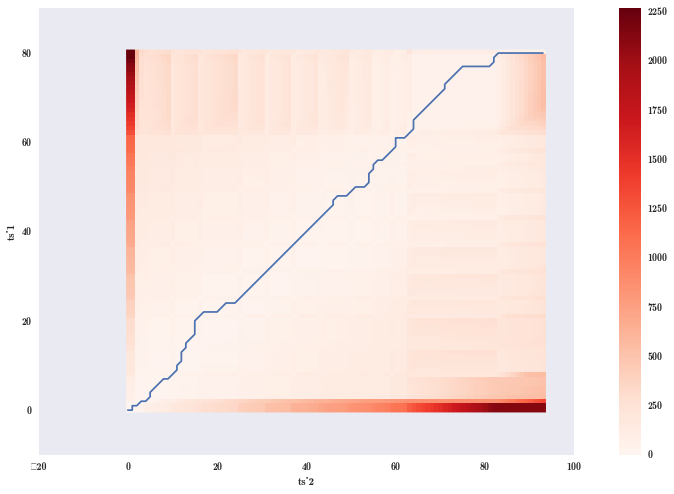

In [21]:
distance_cost_plot(accumulated_cost)
plt.plot(path_ts_2, path_ts_1);

The above plot shows the optimum warping path which minimizes the sum of distance (DTW distance) along the path. Let us wrap up the function by also incorporating the DTW distance between the two signals as well.

In [22]:
def path_cost(ts_2, ts_1, accumulated_cost, distances):
    path = [[len(ts_2)-1, len(ts_1)-1]]
    cost = 0
    i = len(ts_1)-1
    j = len(ts_2)-1
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])
    path.append([0,0])
    for [y, x] in path:
        cost = cost +distances[x, y]
    return path, cost

In [23]:
path, cost = path_cost(ts_2, ts_1, accumulated_cost, distances)
print path
print cost

[[93, 80], [92, 80], [91, 80], [90, 80], [89, 80], [88, 80], [87, 80], [86, 80], [85, 80], [84, 80], [83, 80], [82, 79], [82, 78], [81, 77], [80, 77], [79, 77], [78, 77], [77, 77], [76, 77], [75, 77], [74, 76], [73, 75], [72, 74], [71, 73], [71, 72], [70, 71], [69, 70], [68, 69], [67, 68], [66, 67], [65, 66], [64, 65], [64, 64], [64, 63], [63, 62], [62, 61], [61, 61], [60, 61], [60, 60], [60, 59], [59, 58], [58, 57], [57, 56], [56, 56], [55, 55], [55, 54], [54, 53], [54, 52], [54, 51], [53, 50], [52, 50], [51, 50], [50, 49], [49, 48], [48, 48], [47, 48], [46, 47], [46, 46], [45, 45], [44, 44], [43, 43], [42, 42], [41, 41], [40, 40], [39, 39], [38, 38], [37, 37], [36, 36], [35, 35], [34, 34], [33, 33], [32, 32], [31, 31], [30, 30], [29, 29], [28, 28], [27, 27], [26, 26], [25, 25], [24, 24], [23, 24], [22, 24], [21, 23], [20, 22], [19, 22], [18, 22], [17, 22], [16, 21], [15, 20], [15, 19], [15, 18], [15, 17], [14, 16], [13, 15], [13, 14], [12, 13], [12, 12], [12, 11], [11, 10], [11, 9], 